# 🔴 RetroPGF3 Anonymized Voting Analysis 

Data available here:
<br>https://github.com/ethereum-optimism/op-analytics/blob/main/rpgf/rpgf3/results/anonymized_project_votes.df_projects

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
matplotlib.rcParams.update({'text.usetex': False, 'font.family': 'Arial'})
warnings.filterwarnings("ignore")

RED = '#FF0420'
CMAP = 'bwr'

# Part 1. Prep and do some variance analysis on the data

In [2]:
# load a local copy of the data
df_projects = pd.read_csv("../data/anonymized_project_votes.csv")

# shorten name and remove special characters
df_projects['project_name'] = df_projects['project_name'].apply(lambda string: "".join([s for s in string[:25]]))# if s.isalnum() or s.isspace()]))

# turn the vote amounts into a list of values
df_projects['amount'] = df_projects['amount'].apply(eval)

# run some basic stats analysis
df_projects['mean'] = round(df_projects['amount'].apply(lambda amt: np.mean(amt)))
df_projects['std'] = round(df_projects['amount'].apply(lambda amt: np.std(amt)))
df_projects['median'] = round(df_projects['amount'].apply(lambda amt: np.median([x for x in amt if x])))
df_projects['median_w_zeroes'] = round(df_projects['amount'].apply(lambda amt: np.median(amt)))
df_projects['max'] = df_projects['amount'].apply(lambda amt: max(amt))

df_projects['max_to_median'] = df_projects['max'] / df_projects['median']
df_projects['coeff_variance'] = df_projects['std'] / df_projects['mean']
df_projects['zeroes'] = df_projects['amount'].apply(lambda amt: len([x for x in amt if not x]))
df_projects['zero_impact'] = df_projects['median'] - df_projects['median_w_zeroes']
df_projects['500Ks'] = df_projects['amount'].apply(lambda amt: len([x for x in amt if x >= 500_000]))
df_projects['5Ms'] = df_projects['amount'].apply(lambda amt: len([x for x in amt if x == 5_000_000]))

# count num votes more than 2 std deviations to the right
df_projects['outliers'] = df_projects.apply(lambda row: len([x for x in row['amount'] if row['std'] and (x-row['mean'])/row['std'] > 2]), axis=1)

# simple metric to measure how divisive a project might be
df_projects['divisive_score'] = np.sqrt(df_projects['zeroes']) * np.sqrt(df_projects['outliers'])

df_projects.head(1)

project_name                                             amount  \
0     0xDeFiTH  [100000.0, 1700.0, 0.0, 5000.0, 0.0, 2000.0, 4...   

   number_of_votes     mean      std   median  median_w_zeroes       max  \
0               23  11852.0  19858.0  10000.0           8900.0  100000.0   

   max_to_median  coeff_variance  zeroes  zero_impact  500Ks  5Ms  outliers  \
0           10.0        1.675498       2       1100.0      0    0         1   

   divisive_score  
0        1.414214

## High level voting stats

In [3]:
df_projects[['number_of_votes', 'zeroes', '5Ms']].sum()

number_of_votes    21813
zeroes               788
5Ms                   61
dtype: int64

## Histogram of votes by OP amount

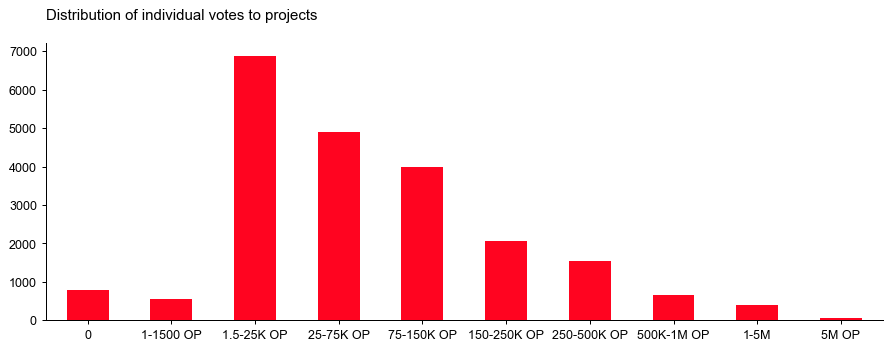

In [4]:
fig, ax = plt.subplots(figsize=(12,4), dpi=90, facecolor='WHITE')
(
    pd.cut(
        pd.Series([x for amts in df_projects['amount'] for x in amts]), 
        bins=[-np.inf, 0, 1500, 25_000, 75_000, 150_000, 
              250_000, 500_000, 1_000_000, 4_999_999, np.inf],
        labels=["0", "1-1500 OP", "1.5-25K OP", "25-75K OP", "75-150K OP", "150-250K OP", 
                "250-500K OP", "500K-1M OP", "1-5M", "5M OP"]
    )
    .value_counts()
    .sort_index()
    .plot(
        kind='bar', 
        color=RED, 
        ax=ax
    )
)
plt.xticks(rotation=0)
ax.set_title("Distribution of individual votes to projects\n", loc='left')
sns.despine()

## Arrive at a final project dataframe

In [5]:
# remove projects that failed to make quorum
df_projects = df_projects[df_projects['number_of_votes'] >= 17]

# Part 2. Categorize projects based on popularity and variance

In [6]:
VOTE_THRESH = df_projects['number_of_votes'].median()
VAR_THRESH = df_projects['coeff_variance'].median()
print(VOTE_THRESH, VAR_THRESH)

36.0 1.350979861388984


## Visualize categories as a 2x2

Text(0.5, 0, 'Number of votes')

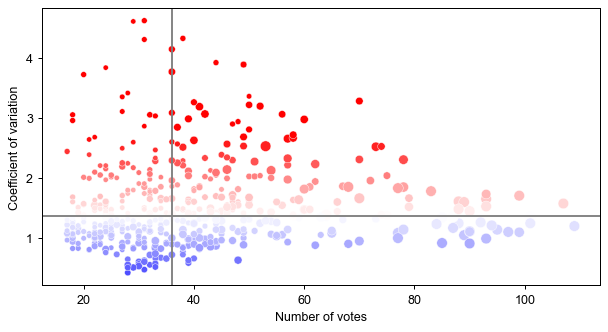

In [7]:
fig, ax = plt.subplots(figsize=(8,4), dpi=90)
(
    sns.scatterplot(
        data=df_projects, 
        x='number_of_votes', 
        y='coeff_variance', 
        size='median', 
        hue='coeff_variance', 
        hue_norm=(0,VAR_THRESH*2), 
        palette=CMAP, 
        size_norm=(10_000,200_000), 
        legend=False)
)
ax.axhline(VAR_THRESH, color='gray')
ax.axvline(VOTE_THRESH, color='gray')
ax.set_ylabel("Coefficient of variation")
ax.set_xlabel("Number of votes")

## Assign a category to each project

In [8]:
def categorize(votes, coeff):
    if coeff < VAR_THRESH:
        type_ = "Lower variance"
    else:
        type_ = "Higher variance"
    if votes < VOTE_THRESH:
        type_ += ", less well-known"
    else:
        type_ += ", more well-known"
    return type_
        
df_projects['category'] = df_projects.apply(lambda x: categorize(x['number_of_votes'], x['coeff_variance']), axis=1)
df_projects['category'].value_counts()

category
Higher variance, more well-known    146
Lower variance, less well-known     144
Lower variance, more well-known     107
Higher variance, less well-known    105
Name: count, dtype: int64

## Visualize medians by category

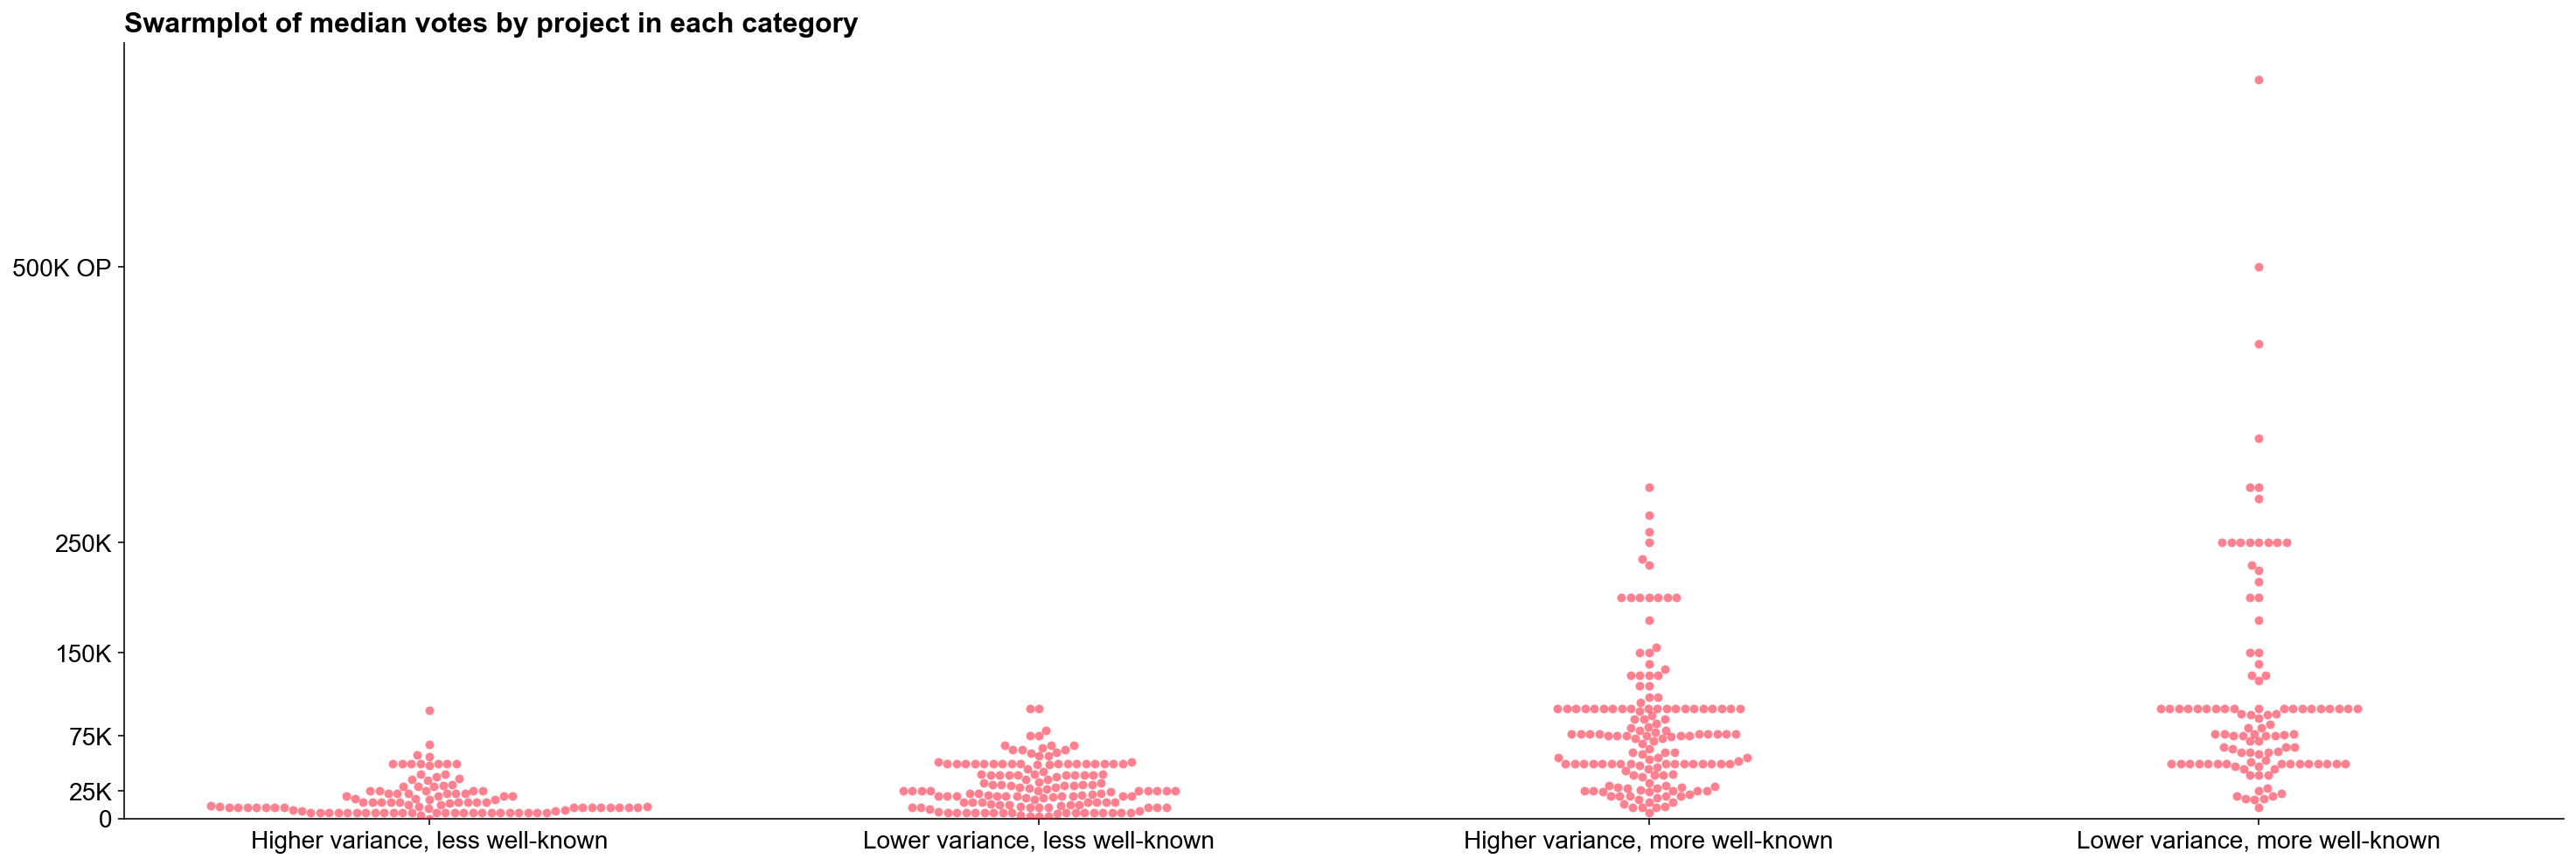

In [9]:
fig, ax = plt.subplots(figsize=(25,8), facecolor='white', dpi=144)
sns.swarmplot(
    data=df_projects,#df_projects[df_projects['category'].str.contains("less")==True],
    x='category',
    y='median_w_zeroes',
    color=RED,
    alpha=.5,
    size=5,
    dodge=.9
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticks([0, 25_000, 75_000, 150_000, 250_000, 500_000])
ax.set_yticklabels(["0", "25K", "75K", "150K", "250K", "500K OP"], fontsize=14)
plt.xticks(fontsize=14)
ax.set_ylim(0,)
ax.set_title("Swarmplot of median votes by project in each category", loc='left', fontsize=16, weight='bold')
sns.despine()

## Create a 5th category for "divisive" projects

In [10]:
divisive_filter = (
    (df_projects['divisive_score']>0) 
    & (df_projects['zeroes']>1) 
    & (df_projects['500Ks']>1)
)
df_projects.loc[divisive_filter, 'category'] = 'Divisive'
df_projects['category'].value_counts()

category
Lower variance, less well-known     144
Higher variance, more well-known    124
Higher variance, less well-known    105
Lower variance, more well-known      96
Divisive                             33
Name: count, dtype: int64

## Unstack the voting data

In [11]:
votes = []
for _, row in df_projects.iterrows():
    amounts = row['amount']
    n = row['project_name']
    c = row['category']
    for a in amounts:
        votes.append((n, min(max(a,.1),500_000), c))
df_votes = pd.DataFrame(votes, columns=['project', 'vote', 'category'])
df_votes.head(1)

project      vote                          category
0  0xDeFiTH  100000.0  Higher variance, less well-known

## Make a pretty plot for illustrating vote distributions by category

In [12]:
# make a pretty plot ;)
def stripplot(category):
    
    dff = df_votes[df_votes['category'] == category]
    n = len(dff['project'].unique())
    
    fig, ax = plt.subplots(figsize=(5,n/5), dpi=200, facecolor='white')
    sns.stripplot(
        dff, 
        y='project', 
        x='vote', 
        hue='vote', 
        palette='coolwarm',
        hue_norm=(0,200_000),
        orient='h', 
        alpha=.5, 
        linewidth=0,
        legend=False,
        dodge=0
    )
    ax.set_xlim(-20_000,520_000)

    for lbl in ax.get_yticklabels():
        p = lbl.get_text()
        y = lbl.get_position()[1]
        right = len(dff[(dff['project']==p) & (dff['vote']==500_000)])
        if right:
            ax.text(s=right, x=510_000, y=y, ha='left', va='center', fontsize=6)
        left = len(dff[(dff['project']==p) & (dff['vote']==0.1)])
        if left:
            ax.text(s=left, x=-10_000, y=y, ha='right', va='center', fontsize=6)

    ax.grid(color='grey', linestyle='--', linewidth=.5)        
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.tick_params(direction='out', length=0, width=.5, grid_alpha=0.5)
    
    title = f"Distribution of {len(dff):,} votes across {n} '{category.lower()}' projects\n"
    ax.set_title(title, loc='left', fontsize=8, weight='bold')
    ax.set_xlabel("")
    ax.set_xticks([0, 25_000, 75_000, 150_000, 250_000, 500_000])
    ax.set_xticklabels(["0", "25K", "75K", "150K", "250K", "500K+"], fontsize=8)
    plt.yticks(fontsize=8)
    ax.set_ylabel("")

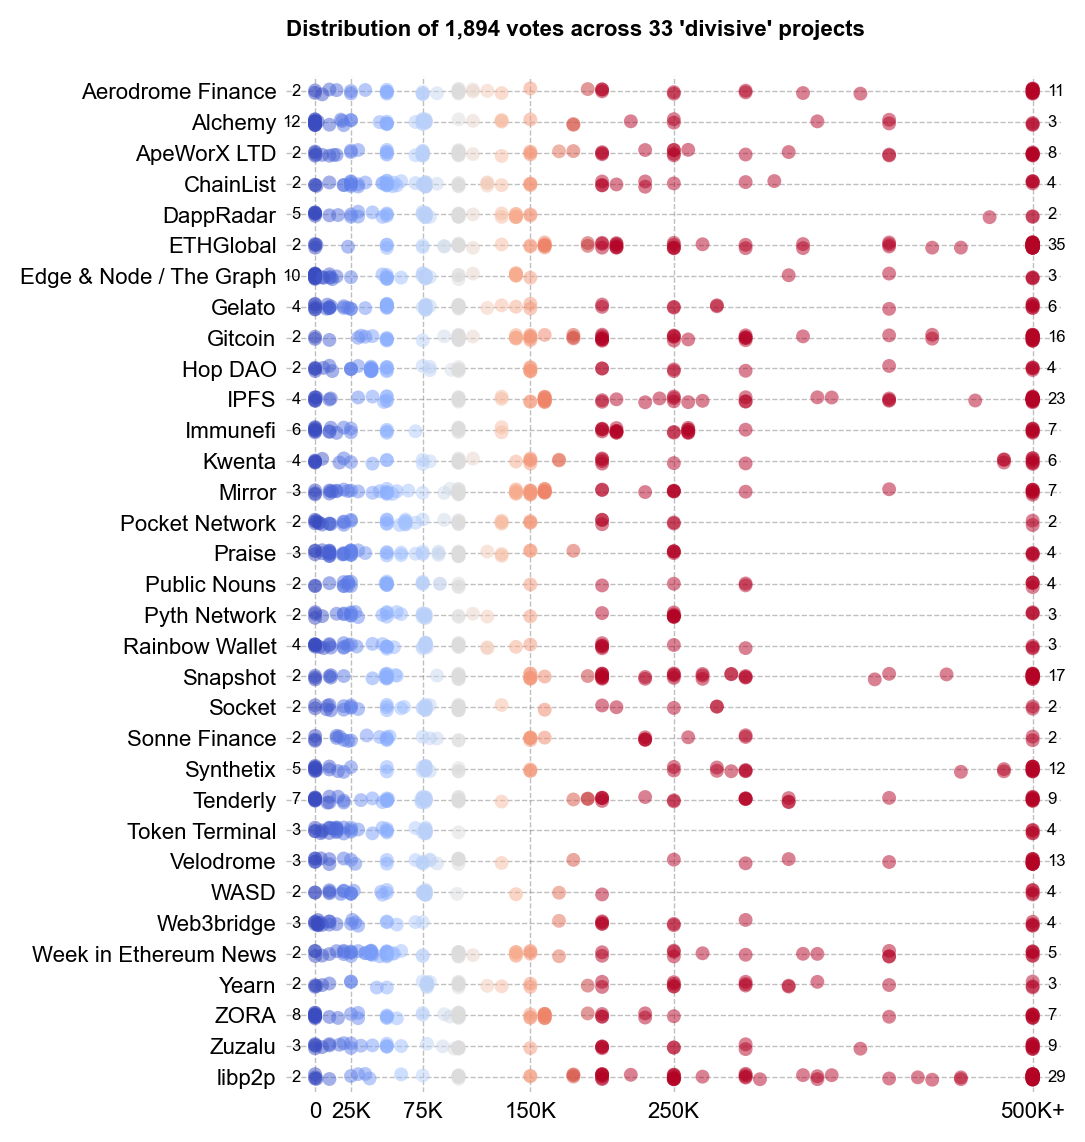

In [13]:
stripplot("Divisive")

# Part 3. Assess impact of zero votes on projects

In [14]:
# zeroes impact
(
    df_projects
    .sort_values(by='zero_impact', ascending=False)
    .head(15)
    [['project_name', 'number_of_votes', 'zeroes', 'median', 'median_w_zeroes', 'zero_impact']]
    .set_index('project_name', drop=True)
    .applymap(int)
)

number_of_votes  zeroes  median  median_w_zeroes  zero_impact
project_name                                                               
Immunefi                   53       6  200000           130000        70000
Synthetix                  54       5  150000           100000        50000
ZORA                       59       8  150000           100000        50000
Synapse Labs               29       6   75000            25000        50000
Kwenta                     46       4  145000           105000        40000
Solidity                  109       1  465000           430000        35000
NFTEarth                   20      12   27500                0        27500
Clipper                    23       2   77000            50000        27000
Public Nouns               37       2   75000            50000        25000
Synapse DAO                33       6   75000            50000        25000
Messari                    39       8   50000            25000        25000
beaconcha.in               94       1  250000           225000        25000
ETHGlobal                  90       2  285000           260000        25000
Tenderly                   74       7  100000            77000        23000
Web3bridge                 36       3   50000            29000        21000

In [15]:
# most zeroed
df_projects.sort_values(by='zeroes').tail(15)[['project_name', 'zeroes', 'number_of_votes']]

project_name  zeroes  number_of_votes
43           Bankless Africa       5               33
490                Synthetix       5               54
133                DappRadar       5               54
205          Flipside Crypto       5               47
488             Synapse Labs       6               29
487              Synapse DAO       6               33
334          Nacion Bankless       6               40
252                 Immunefi       6               53
497                 Tenderly       7               74
317                  Messari       8               39
567                     ZORA       8               59
45              Bankless DAO       8               47
173  Edge & Node / The Graph      10               58
20                   Alchemy      12               59
333                 NFTEarth      12               20

## Illustrate impact on a single project

In [16]:
def barchart(lst, title):
    fig, ax = plt.subplots(figsize=(10,2), dpi=144, facecolor='white')
    series = pd.Series(lst).sort_values(ascending=False) / 1000
    series.plot(kind='bar', color=RED, alpha=.5, ax=ax, width=1)
    ax.set_xlim(0,len(series))
    ax.set_xticks([])
    ax.set_ylim(0,500)
    ax.set_yticks([0,100,200,300,400,500])
    ax.set_yticklabels([0,100,200,300,400,"500K+"])
    
    med = series.median()
    ax.axhline(med, color='grey', linestyle='--', lw=1)
    ax.text(s=f"Median: {med:.0f}K OP", x=len(series), y=series.median(), va='bottom', ha='right')    
    ax.set_title(f"{title}\n", loc='left', weight='bold')
    sns.despine()

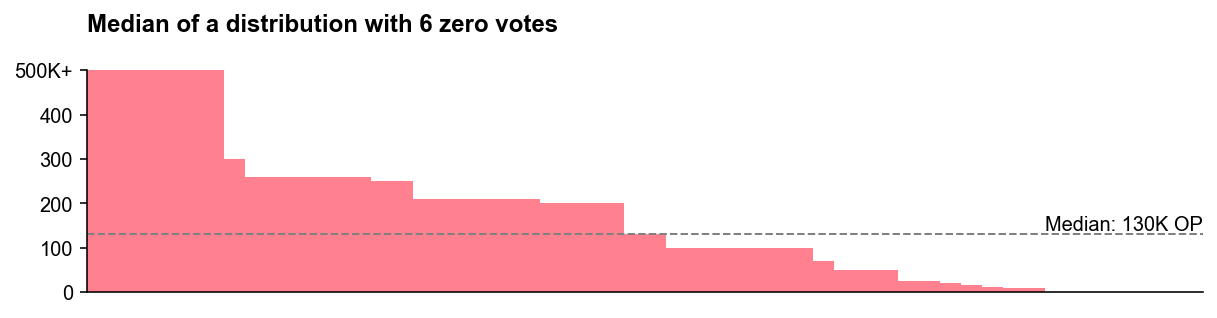

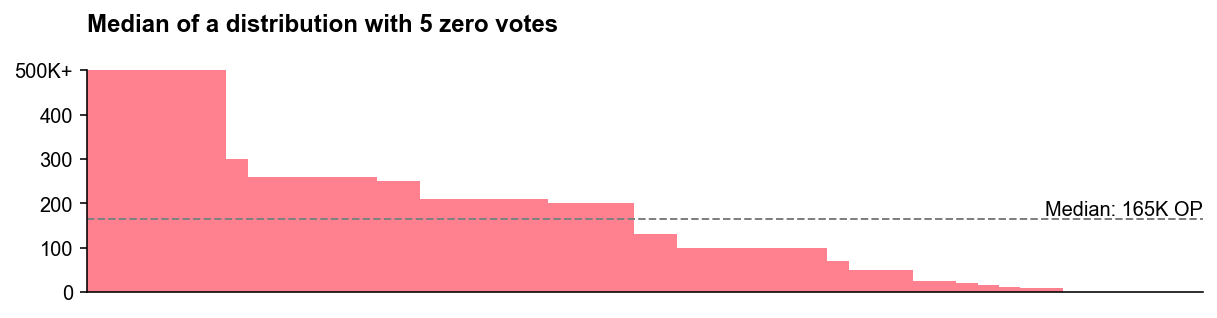

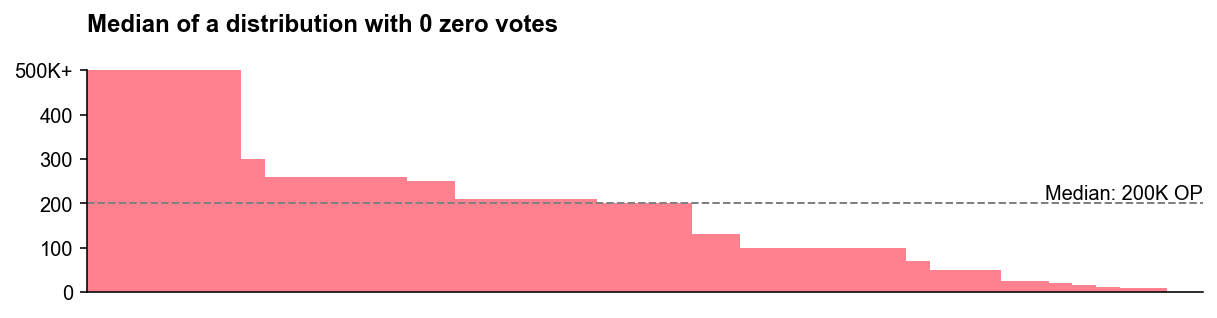

In [17]:
sample_zeroes = sorted(list(df_projects[df_projects['project_name'] == 'Immunefi']['amount'])[0])

num_zeroes = 7
for z in [0,1,6]:
    barchart(sample_zeroes[z:], f"Median of a distribution with {num_zeroes-(z+1)} zero votes")

Text(0.0, 1.0, "Incremental impact of a zero vote on a project's median token amount")

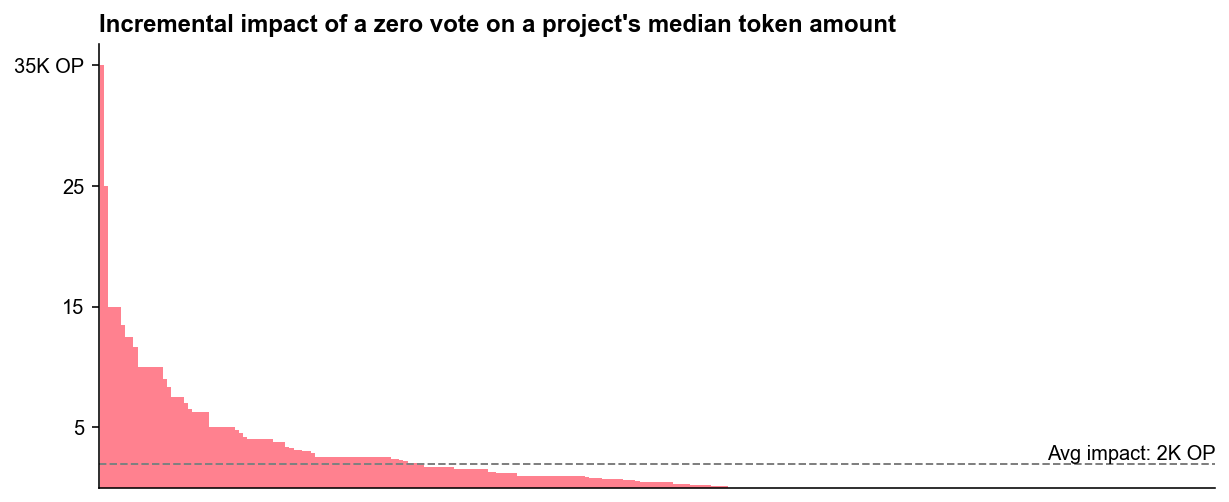

In [18]:
fig, ax = plt.subplots(figsize=(10,4), dpi=144, facecolor='white')
zero_impact = (
    (df_projects[df_projects['zeroes']>0]['zero_impact'] 
    / df_projects[df_projects['zeroes']>0]['zeroes'])
    .sort_values(ascending=False)
    / 1000
)
zero_impact.plot(kind='bar', color=RED, alpha=.5, ax=ax, width=1)
ax.set_xticks([])
ax.set_yticks([5,15,25,35])
ax.set_yticklabels([5,15,25,"35K OP"])
ax.axhline(zero_impact.mean(), color='grey', linestyle='--', lw=1)
avg_impact = zero_impact.mean()
ax.text(s=f"Avg impact: {avg_impact:,.0f}K OP", x=len(zero_impact), y=avg_impact, va='bottom', ha='right')
sns.despine()
ax.set_title("Incremental impact of a zero vote on a project's median token amount", loc='left', weight='bold')

## Identify projects most affected by zeroes

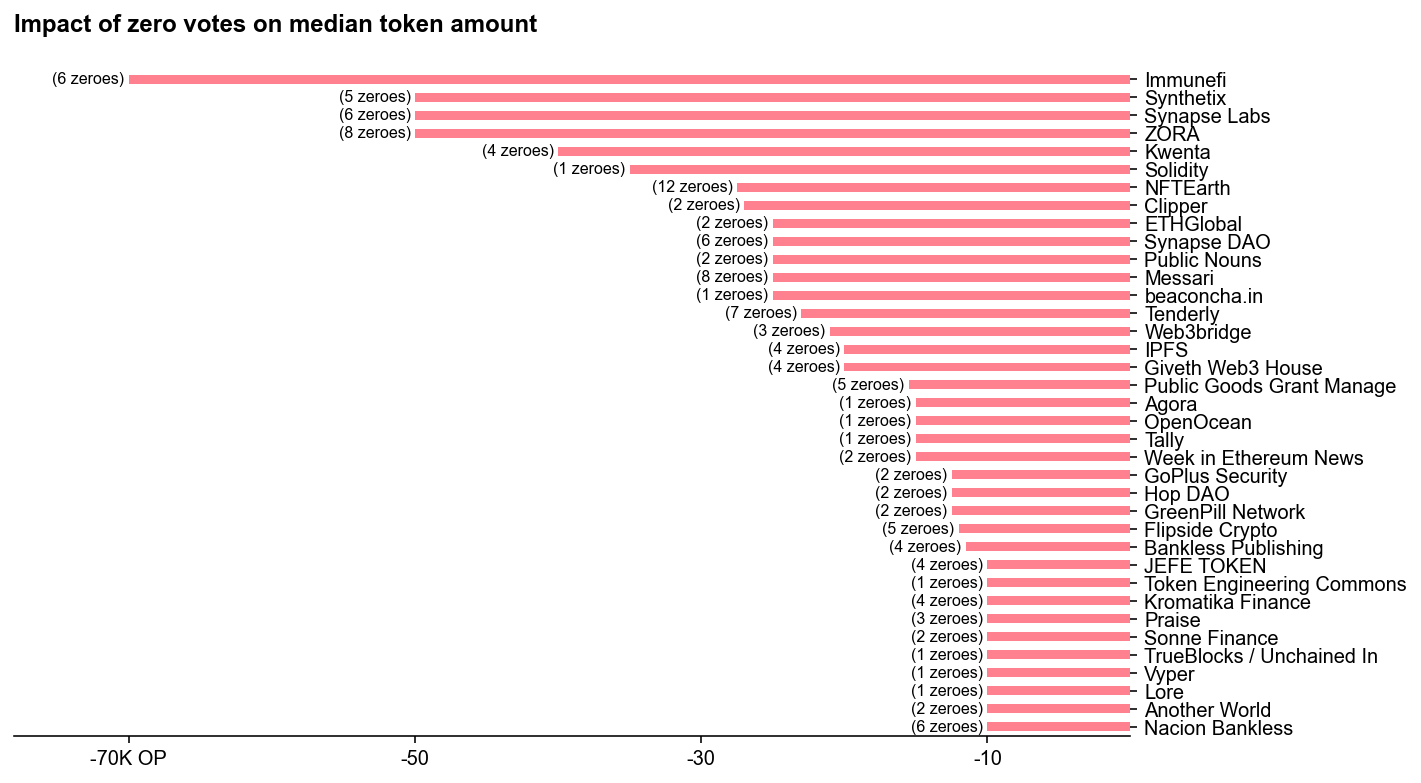

In [19]:
fig, ax = plt.subplots(figsize=(10,6), dpi=144, facecolor='white')
zer0 = (
    -df_projects[df_projects['zero_impact']>=10000]
    .set_index('project_name')
    ['zero_impact'] 
    .sort_values() / 1000
)
zer0.plot(kind='barh', ax=ax, color=RED, alpha=.5)
for lbl in ax.get_yticklabels():
    
    p = lbl.get_text()
    x = zer0[p]
    y = lbl.get_position()[1]
    num = df_projects[df_projects['project_name']==p]['zeroes'].max()
    txt = f"({num} zeroes) "
    ax.text(s=txt, x=x, y=y, ha='right', va='center', fontsize=8)

ax.set_title("Impact of zero votes on median token amount\n", loc='left', weight='bold')    
ax.set_ylabel("")
ax.spines[['right', 'top', 'left']].set_visible(False)
ax.set_xlim(-78,0)
ax.set_xticks([-70,-50,-30,-10])
ax.set_xticklabels(["-70K OP",-50,-30,-10])
ax.yaxis.tick_right()

# Appendix: make some more pretty plots

In [20]:
CATS = list(df_projects['category'].unique())

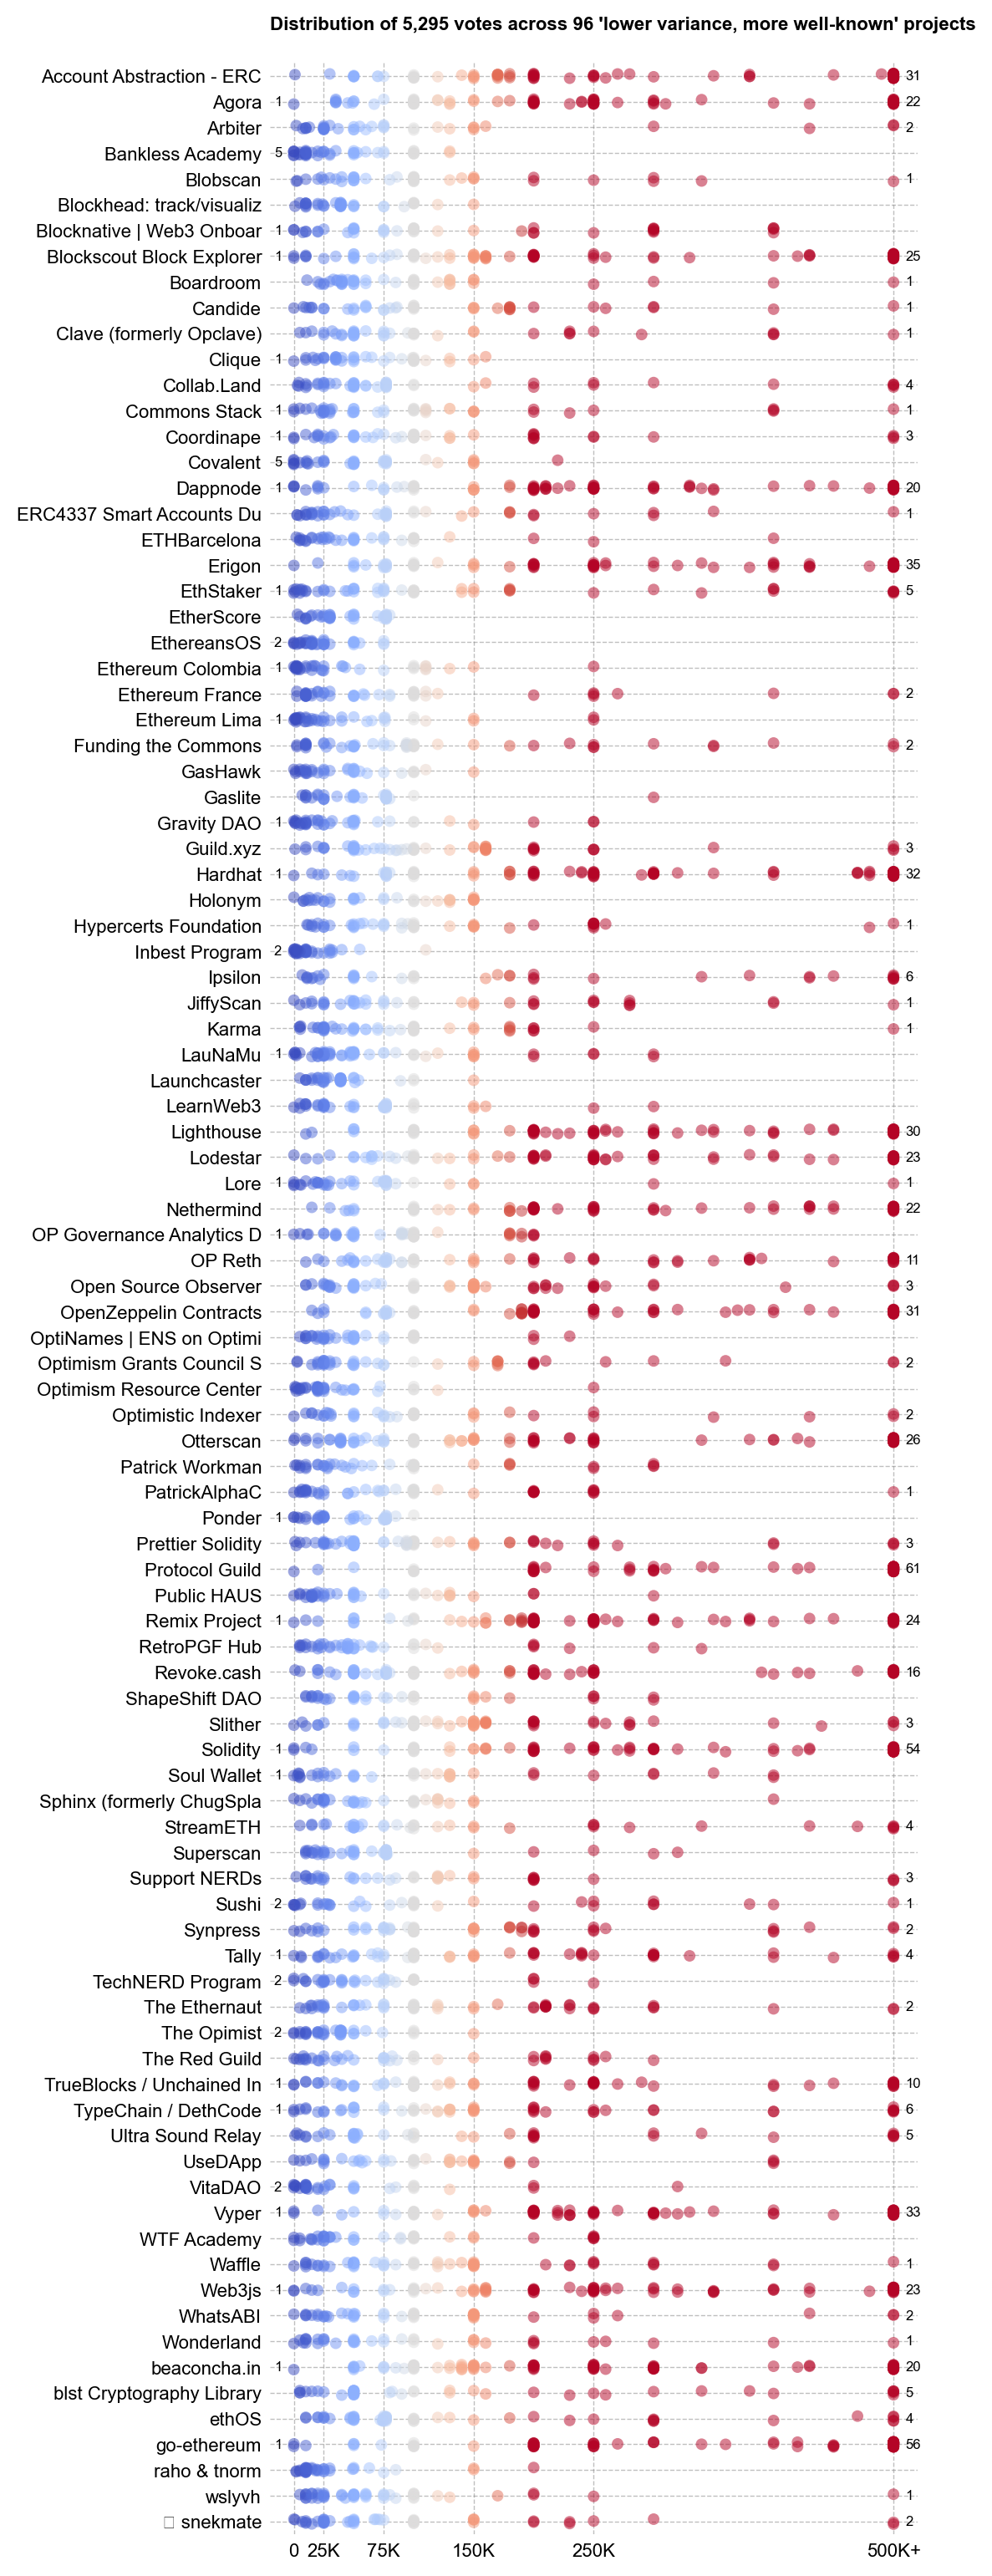

In [21]:
stripplot(CATS[3])

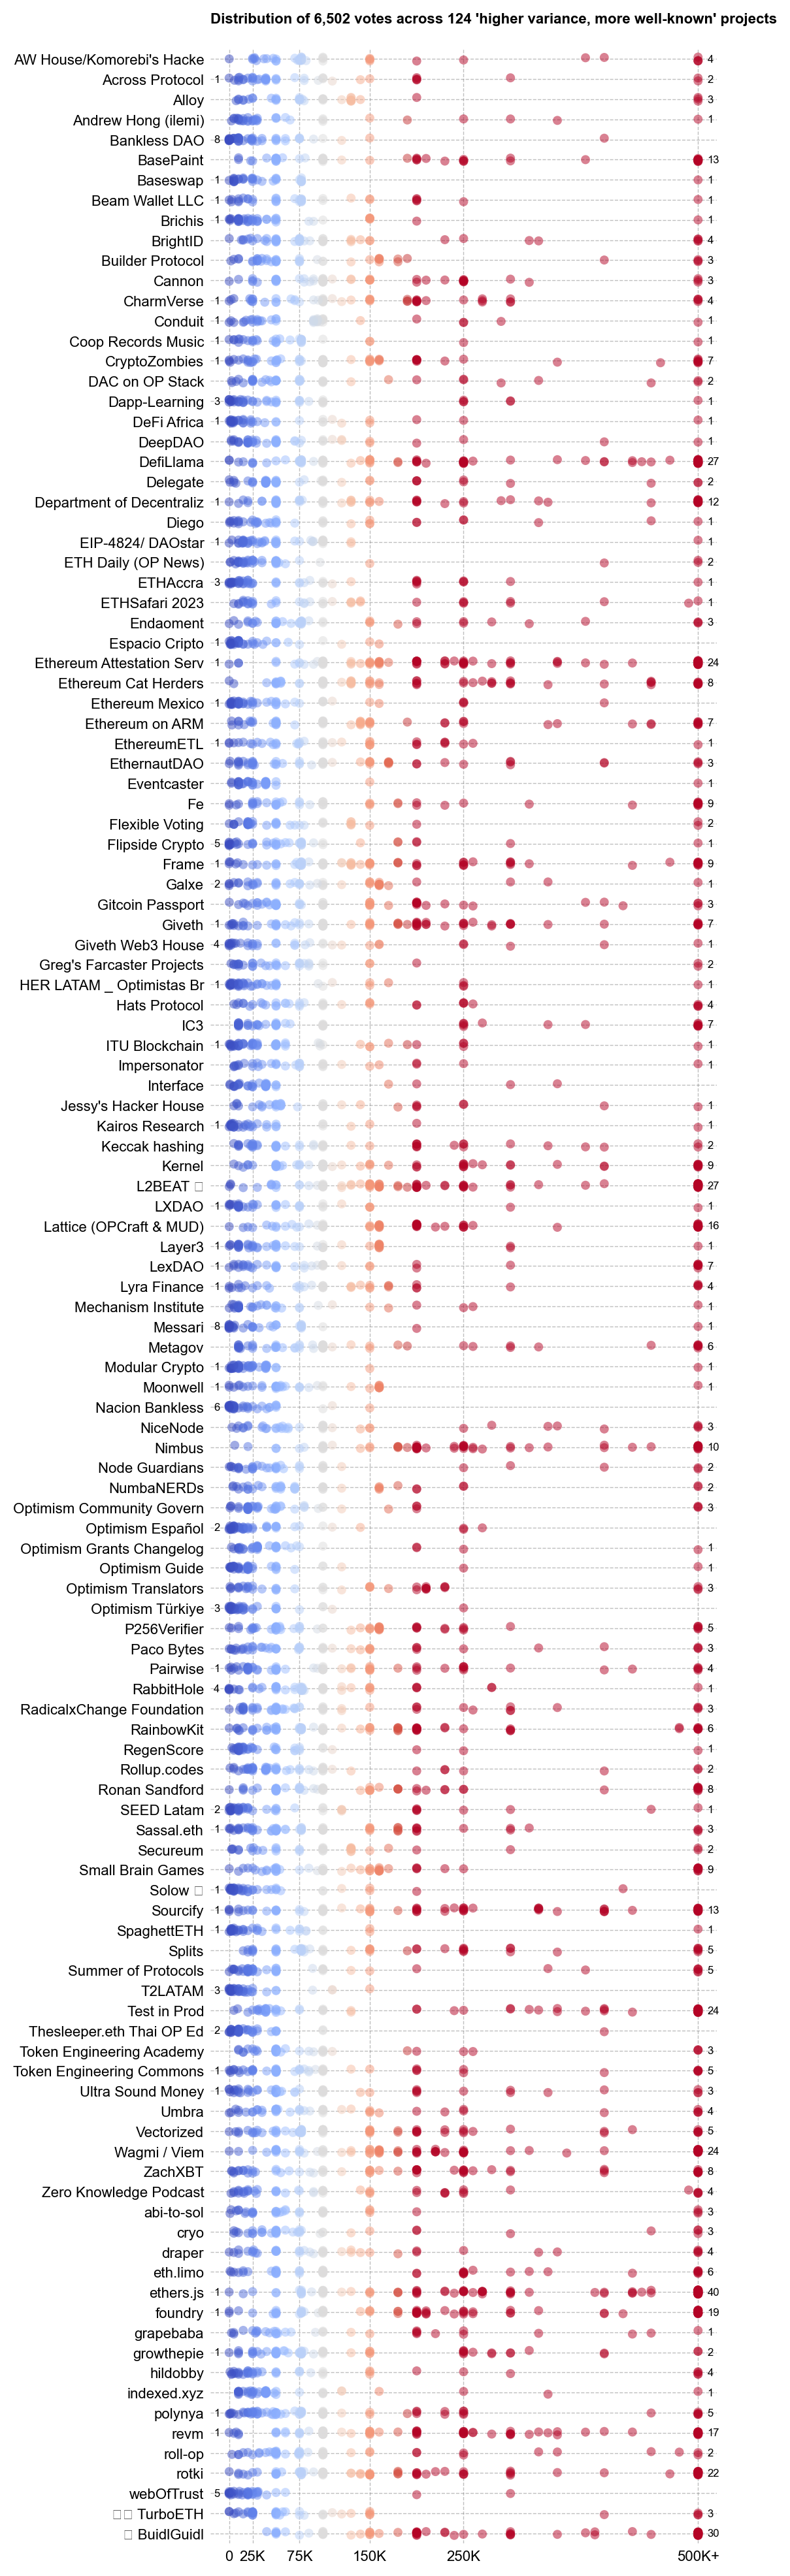

In [22]:
stripplot(CATS[2])

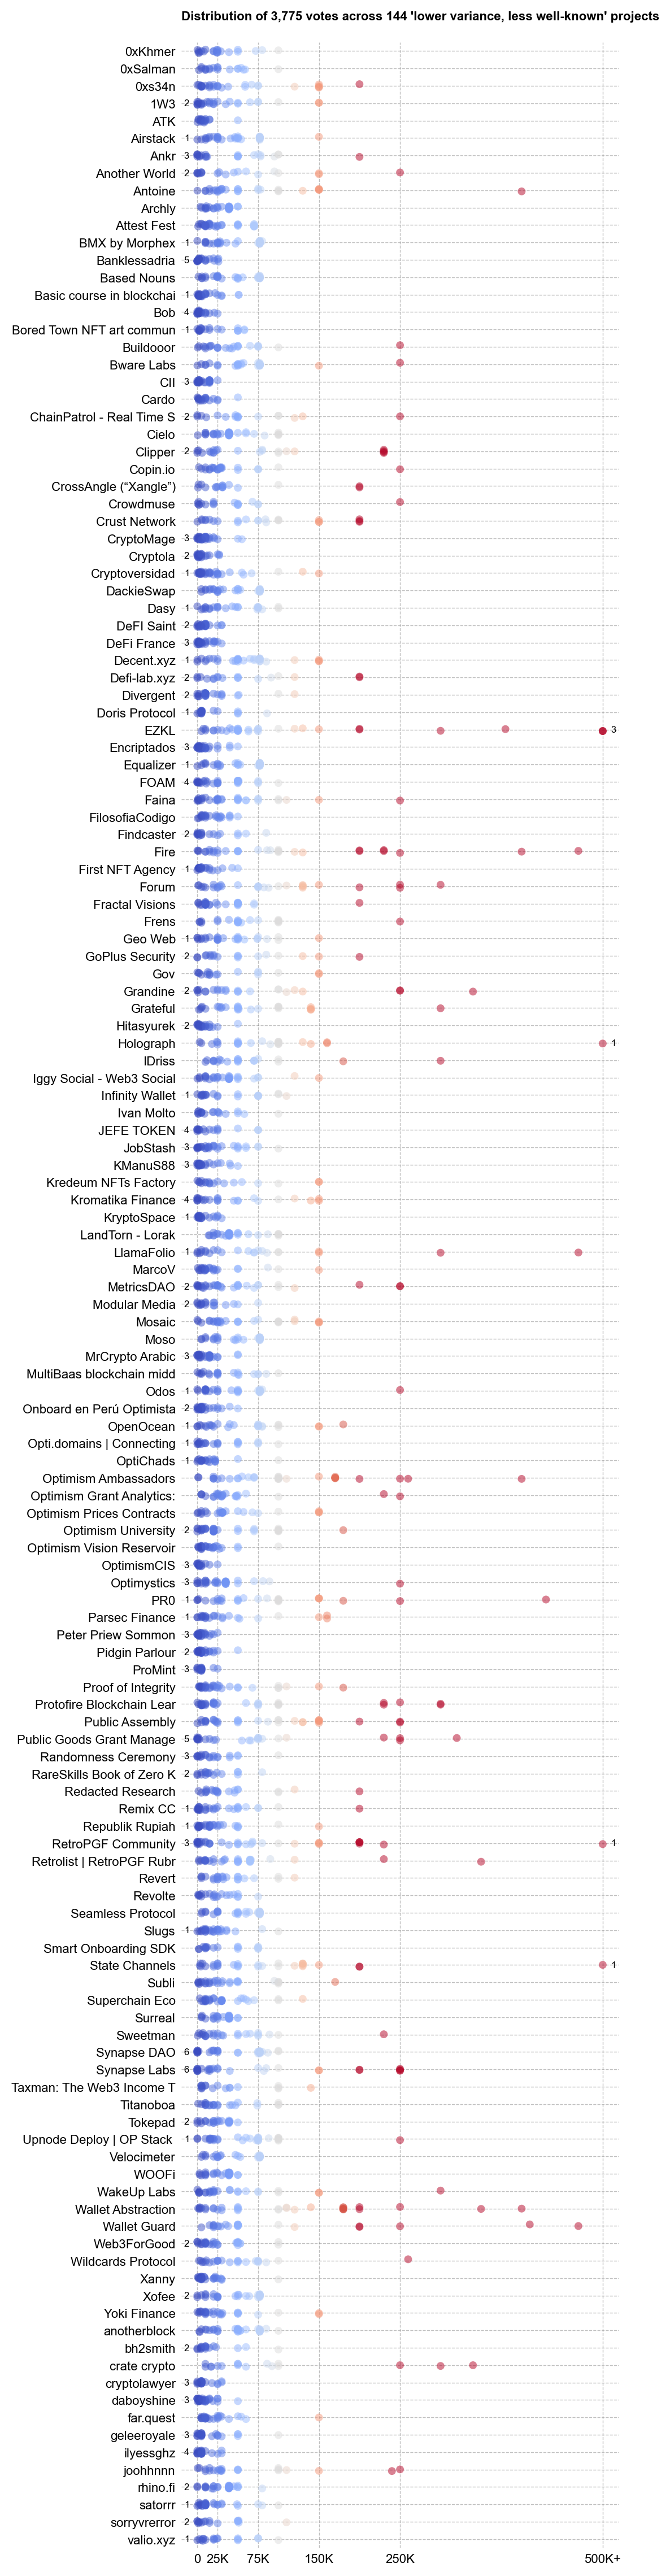

In [23]:
stripplot(CATS[1])

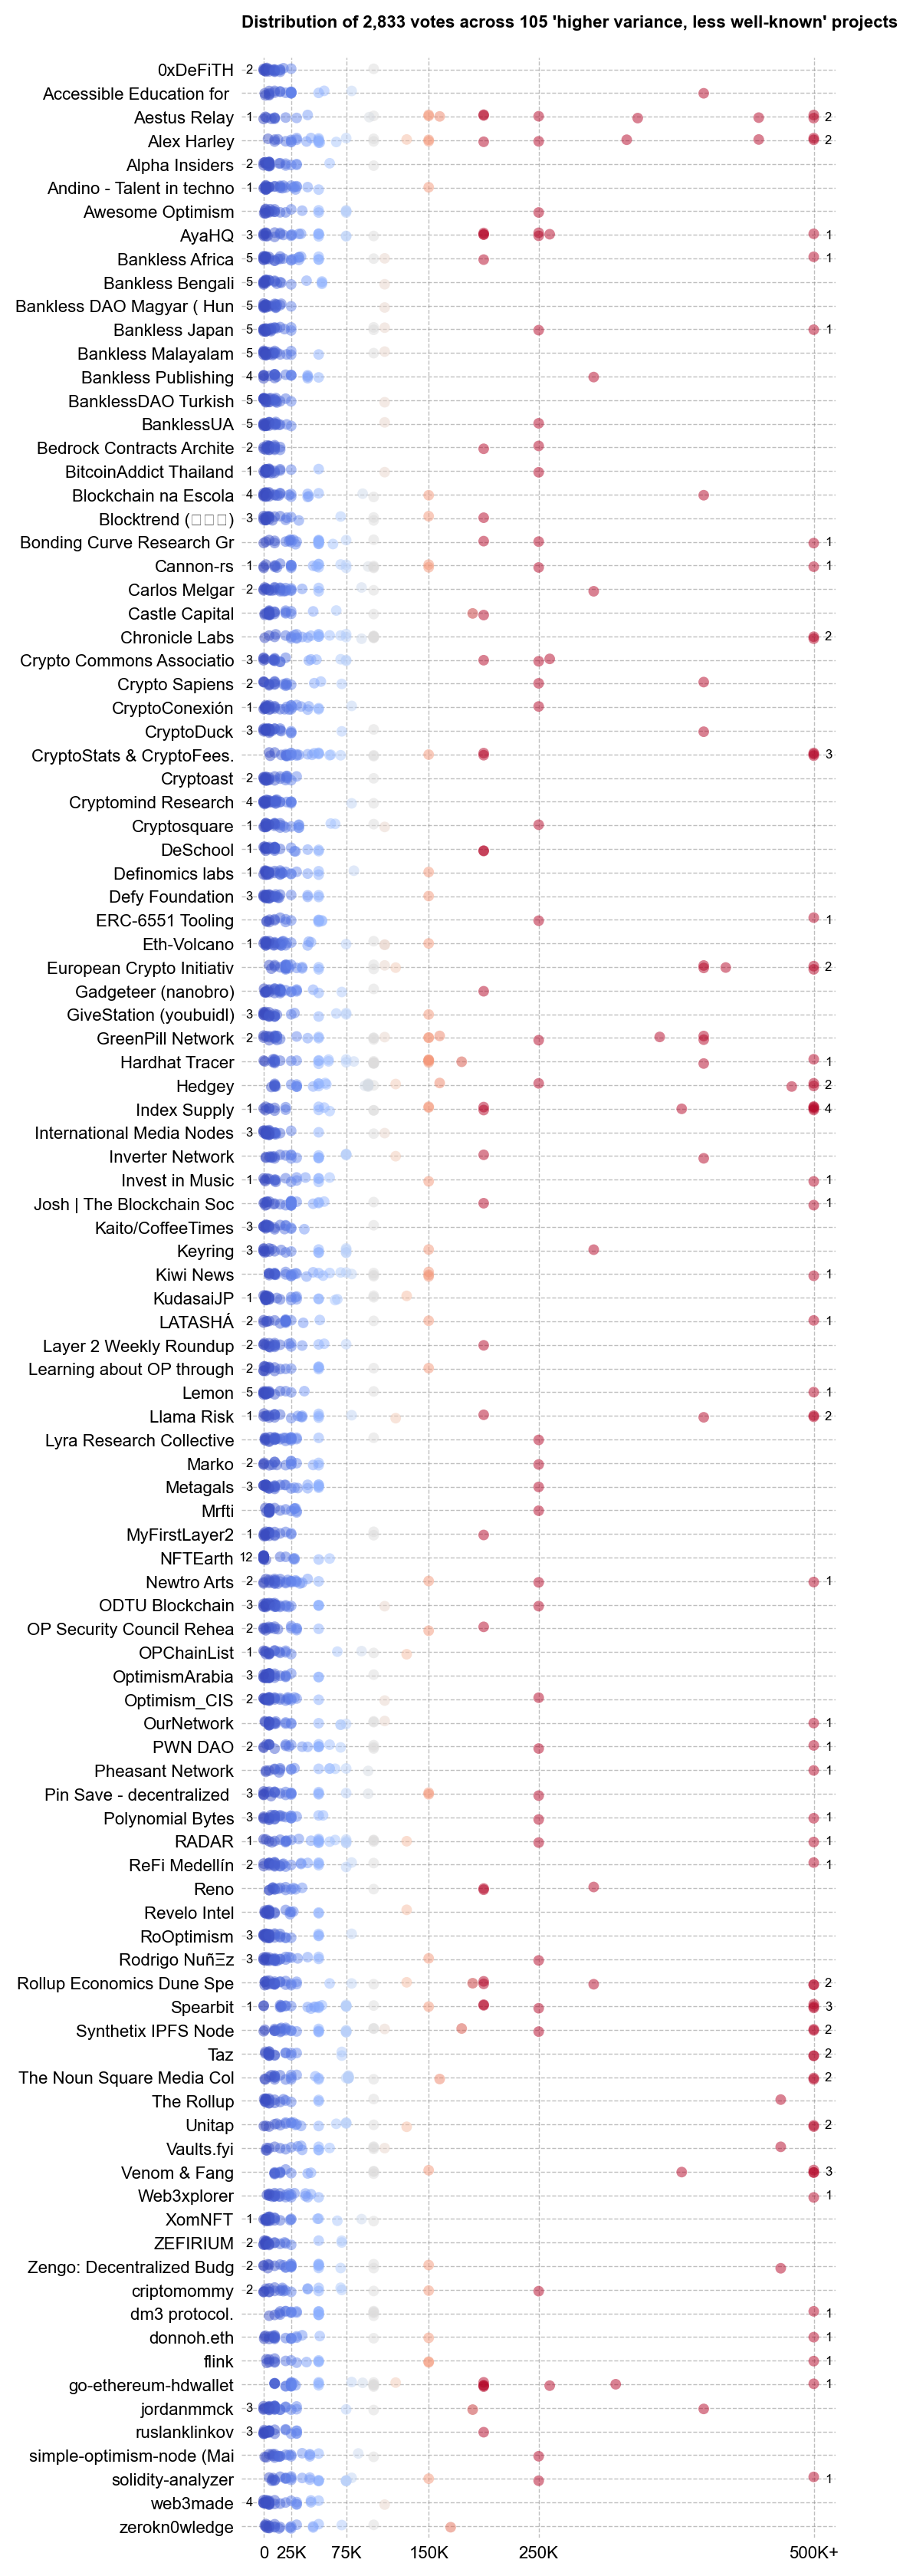

In [24]:
stripplot(CATS[0])